In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from numpy import meshgrid
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.autograd import gradcheck
from numpy import exp, mod, meshgrid, cos, sin, exp, pi
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import shift
from math import sqrt
from scipy.sparse import diags
from scipy.linalg import cholesky

## Generate data

In [2]:
def generate_data(Nx, Nt, case, noise_percent=0.2):
    Tmax = 0.5  # total time
    L = 1  # total domain size
    sigma = 0.015  # standard diviation of the puls
    x = np.arange(0, Nx) / Nx * L
    t = np.arange(0, Nt) / Nt * Tmax
    dx = x[1] - x[0]
    dt = t[1] - t[0]
    c = 1
    [X, T] = meshgrid(x, t)
    X = X.T
    T = T.T

    if case == "crossing_waves":
        nmodes = 1
        fun = lambda x, t: exp(-((mod((x - c * t), L) - 0.1) ** 2) / sigma**2) + exp(
            -((mod((x + c * t), L) - 0.9) ** 2) / sigma**2
        )

        # Define your field as a list of fields:
        # For example the first element in the list can be the density of
        # a flow quantity and the second element could be the velocity in 1D
        density = fun(X, T)
        velocity = fun(X, T)
        shifts1 = np.asarray(-c * t)
        shifts2 = np.asarray(c * t)
        Q = density  # , velocity]
        shift_list = [shifts1, shifts2]
    elif case == "sine_waves":
        delta = 0.0125
        # first frame
        q1 = np.zeros_like(X)
        shifts1 = -0.25 * cos(7 * pi * t)
        for r in np.arange(1, 5):
            x1 = 0.25 + 0.1 * r - shifts1
            q1 = q1 + sin(2 * pi * r * T / Tmax) * exp(-((X - x1) ** 2) / delta**2)
        # second frame
        c2 = dx / dt
        shifts2 = -c2 * t
        q2 = np.zeros_like(X)

        x2 = 0.2 - shifts2
        q2 = exp(-((X - x2) ** 2) / delta**2)

        Q = q1 + q2
        nmodes = [4, 1]
        shift_list = [shifts1, shifts2]

    elif case == "sine_waves_noise":
        delta = 0.0125
        # first frame
        q1 = np.zeros_like(X)
        shifts1 = -0.25 * cos(7 * pi * t)
        for r in np.arange(1, 5):
            x1 = 0.25 + 0.1 * r - shifts1
            q1 = q1 + sin(2 * pi * r * T / Tmax) * exp(-((X - x1) ** 2) / delta**2)
        # second frame
        c2 = dx / dt
        shifts2 = -c2 * t

        x2 = 0.2 - shifts2
        q2 = exp(-((X - x2) ** 2) / delta**2)
        # E = 0.1*np.random.random(np.shape(q2))
        Q = q1 + q2  # + E
        indices = np.random.choice(
            np.arange(Q.size), replace=False, size=int(Q.size * noise_percent)
        )
        Q = Q.flatten()
        Q[indices] = 1
        Q = np.reshape(Q, np.shape(q1))
        nmodes = [4, 1]
        shift_list = [shifts1, shifts2]

    elif case == "multiple_ranks":
        delta = 0.0125
        # first frame
        q1 = np.zeros_like(X)
        c2 = dx / dt
        shifts1 = c2 * t
        for r in np.arange(1, 5):
            # x1 = 0.25 + 0.1 * r - shifts1
            x1 = 0.5 + 0.1 * r - shifts1
            q1 = q1 + sin(2 * pi * r * T / Tmax) * exp(-((X - x1) ** 2) / delta**2)
        # second frame
        c2 = dx / dt
        shifts2 = -c2 * t
        q2 = np.zeros_like(X)
        for r in np.arange(1, 3):
            x2 = 0.2 + 0.1 * r - shifts2
            q2 = q2 + cos(2 * pi * r * T / Tmax) * exp(-((X - x2) ** 2) / delta**2)

        Q = q1 + q2
        nmodes = [4, 2]
        shift_list = [shifts1, shifts2]

    return Q, shift_list, nmodes, L, dx, x, t

In [3]:
coefficients1 = [1,0]
coefficients2 = [-1,0]

In [4]:
case = "multiple_ranks"
# case = "sine_waves"
Nx = 100  # number of grid points in x
Nt = Nx // 2  # number of time intervals
seed = 7

In [5]:
np.random.seed(seed)
fields, shift_list, nmodes, L, dx, x, t = generate_data(Nx, Nt, case)
data_shape = [Nx, 1, 1, Nt]
qmat = np.reshape(fields, [Nx, Nt])

In [6]:
torch.manual_seed(seed)

In [7]:
inputs = np.stack([x.repeat(Nt), np.tile(t, Nx)], axis=1)
inputs_tensor = torch.tensor(inputs, dtype=torch.float32)

In [8]:
Q_tensor = torch.tensor(qmat)

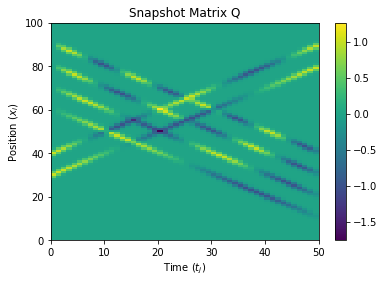

In [9]:
vmin = np.min(qmat)
vmax = np.max(qmat)

plt.pcolor(qmat, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.xlabel('Time ($t_j$)')
plt.ylabel('Position ($x_i$)')
plt.title('Snapshot Matrix Q')
plt.show()

# Define a model

In [10]:
class NuclearNormAutograd(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input_matrix):
        ctx.save_for_backward(input_matrix)
        return torch.linalg.matrix_norm(input_matrix, ord="nuc")

    @staticmethod
    def backward(ctx, grad_output):
        input_matrix, = ctx.saved_tensors
        u, s, v = torch.svd(input_matrix, some=False)
        rank = torch.sum(s > 0).item()
        dtype = input_matrix.dtype
        eye_approx = torch.diag((s > 0).to(dtype)[:rank])
        grad_input = torch.matmul(torch.matmul(u[:, :rank], eye_approx), v[:, :rank].t())
        return grad_input * grad_output.unsqueeze(-1).unsqueeze(-1)

In [11]:
class ShapeShiftNet(nn.Module):
    def __init__(self, p_init_coeffs1, p_init_coeffs2):
        super(ShapeShiftNet, self).__init__()
        
        self.alphas1 = nn.ParameterList(
            [nn.Parameter(torch.tensor([coeff], dtype=torch.float32), requires_grad=True) for coeff in p_init_coeffs1[::-1]]
        )
        self.alphas2 = nn.ParameterList(
            [nn.Parameter(torch.tensor([coeff], dtype=torch.float32), requires_grad=True) for coeff in p_init_coeffs2[::-1]]
        )
        self.elu = nn.ELU()
        
        # Subnetwork for f^1 and shift^1
        self.f1_fc1 = nn.Linear(2, 64)
        self.f1_fc2 = nn.Linear(64, 64)
        self.f1_fc3 = nn.Linear(64, 64)
        self.f1_fc4 = nn.Linear(64, 1)

        # Subnetwork for f^2 and shift^2
        self.f2_fc1 = nn.Linear(2, 64)
        self.f2_fc2 = nn.Linear(64, 64)
        self.f2_fc3 = nn.Linear(64, 64)
        self.f2_fc4 = nn.Linear(64, 1)

        
    def forward(self, x, t):
        # Pathway for f^1 and shift^1
        shift1 = sum([coeff * t**i for i, coeff in enumerate(self.alphas1)])

        x_shifted1 = x + shift1
        f1 = self.elu(self.f1_fc1(torch.cat((x_shifted1, t), dim=1)))
        f1 = self.elu(self.f1_fc2(f1))
        f1 = self.elu(self.f1_fc3(f1))
        f1 = self.f1_fc4(f1)
        
        f1_without_shift = self.elu(self.f1_fc1(torch.cat((x, t), dim=1)))
        f1_without_shift = self.elu(self.f1_fc2(f1_without_shift))
        f1_without_shift = self.elu(self.f1_fc3(f1_without_shift))
        f1_without_shift = self.f1_fc4(f1_without_shift)
        
        
        # Pathway for f^2 and shift^2
        shift2 = sum([coeff * t**i for i, coeff in enumerate(self.alphas2)])

        x_shifted2 = x + shift2
        f2 = self.elu(self.f2_fc1(torch.cat((x_shifted2, t), dim=1)))
        f2 = self.elu(self.f2_fc2(f2))
        f2 = self.elu(self.f2_fc3(f2))
        f2 = self.f2_fc4(f2)
        
        f2_without_shift = self.elu(self.f2_fc1(torch.cat((x, t), dim=1)))
        f2_without_shift = self.elu(self.f2_fc2(f2_without_shift))
        f2_without_shift = self.elu(self.f2_fc3(f2_without_shift))
        f2_without_shift = self.f2_fc4(f2_without_shift)
        
        return f1, f2, shift1, shift2, f1_without_shift, f2_without_shift

In [12]:
init_coefficients1 = [-1,1]
init_coefficients2 = [1,1]

In [13]:
model = ShapeShiftNet(init_coefficients1, init_coefficients2)

torch.manual_seed(seed)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
num_epochs = 500_000
lambda_k = 0.01

for epoch in range(num_epochs + 1):
    x, t = inputs_tensor[:, 0:1], inputs_tensor[:, 1:2]
    optimizer.zero_grad()
    f1_full, f2_full, shift1_pred, shift2_pred, f1_full_nos, f2_full_nos = model(x,t)
    
    frobenius_loss = torch.norm(Q_tensor - f1_full.view(Nx, Nt) - f2_full.view(Nx, Nt), 'fro') ** 2
    
    nuclear_loss_q1 = NuclearNormAutograd.apply(f1_full_nos.view(Nx, Nt))
    nuclear_loss_q2 = NuclearNormAutograd.apply(f2_full_nos.view(Nx, Nt))
    nuclear_loss = lambda_k*(nuclear_loss_q1 + nuclear_loss_q2)
        
    total_loss = frobenius_loss + nuclear_loss

    total_loss.backward(retain_graph=True)
    optimizer.step()
    
    shift_coeffs1 = torch.tensor([p.item() for p in model.alphas1])
    shift_coeffs2 = torch.tensor([p.item() for p in model.alphas2])
    
    if epoch % 100 == 0:
        print(
            f'Epoch {epoch}/{num_epochs}, Frob Loss: {frobenius_loss.item()}, Nuclear Loss: {nuclear_loss.item()}, Total loss: {total_loss.item()},'
            f'Coefficients_1:{[coefficients2[::-1][i] for i in range(len(coefficients2))]}{-shift_coeffs1}, Coefficients_2:{[coefficients1[::-1][i] for i in range(len(coefficients1))]}{-shift_coeffs2}')

Epoch 0/500000, Frob Loss: 5.769545940111651, Nuclear Loss: 0.42233189940452576, Total loss: 6.191877839516176,Coefficients_1:[0, -1]tensor([-0.7294, -0.0691]), Coefficients_2:[0, 1]tensor([-0.4519, -1.0051])



KeyboardInterrupt



In [16]:
combined = f1_full + f2_full
Q_tilde = combined.view(Nx, Nt).detach().numpy()

Text(0.5, 1.0, '$\\mathbf{Q}^2$')

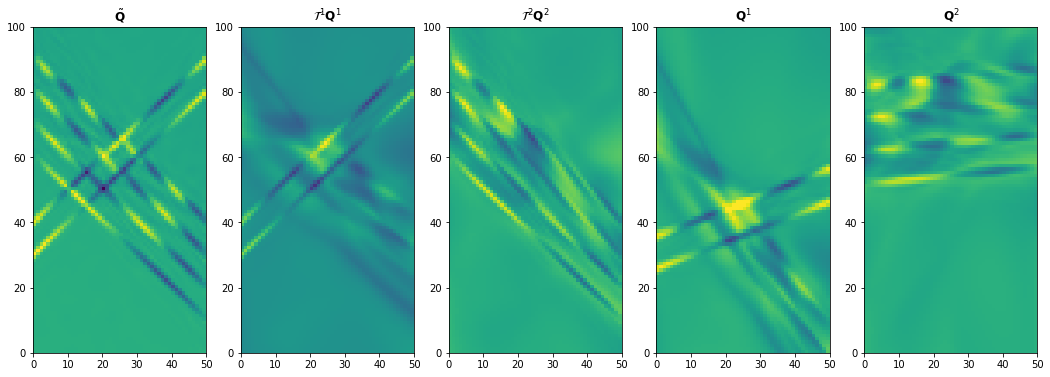

In [16]:
#0.01
#frob 6
# 200_000

fig, axs = plt.subplots(1, 5, figsize=(18, 6))
vmin = np.min(Q_tilde)
vmax = np.max(Q_tilde)

#Qtilde
axs[0].pcolor(Q_tilde, vmin=vmin, vmax=vmax)
axs[0].set_title(r"$\tilde{\mathbf{Q}}$")
#axs[0].set_xlabel('$t_j$)')
#axs[0].set_ylabel('Position ($x_i$)')

# f^1
axs[1].pcolor(f1_full.view(Nx, Nt).detach().numpy(), vmin=vmin)
axs[1].set_title(r"$\mathcal{T}^1\mathbf{Q}^1$")
#axs[1].set_xlabel('Time ($t_j$)')
#axs[1].set_ylabel('Position ($x_i$)')

# f^2
axs[2].pcolor(f2_full.view(Nx,Nt).detach().numpy(), vmin=vmin, vmax=vmax)
axs[2].set_title(r"$\mathcal{T}^2\mathbf{Q}^2$")
#axs[2].set_xlabel('Time ($t_j$)')
#axs[2].set_ylabel('Position ($x_i$)')

# f^1
axs[3].pcolor(f1_full_nos.view(Nx,Nt).detach().numpy(), vmin=vmin, vmax=vmax)
axs[3].set_title(r"$\mathbf{Q}^1$")
#axs[3].set_xlabel('Time ($t_j$)')
#axs[3].set_ylabel('Position ($x_i$)')

# f^2
axs[4].pcolor(f2_full_nos.view(Nx,Nt).detach().numpy(), vmin=vmin, vmax=vmax)
axs[4].set_title(r"$\mathbf{Q}^2$")
#axs[4].set_xlabel('Time ($t_j$)')
#axs[4].set_ylabel('Position ($x_i$)')

In [38]:
torch.save(model.state_dict(), 'model_weights.pth')